In [11]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score

In [29]:
NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'TECHM.NS'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'ADX', 'CCI', 'STOCH', 'ATR']

[*********************100%***********************]  1 of 1 completed
3784


<AxesSubplot:xlabel='Date'>

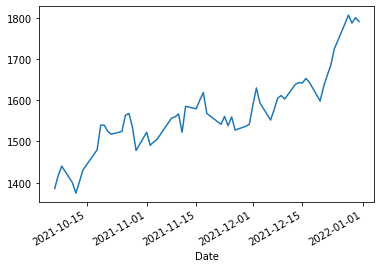

In [30]:
start = (datetime.date.today() - datetime.timedelta(NUM_DAYS))
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(len(data))

tmp = data.iloc[-60:]
tmp['close'].plot()

<AxesSubplot:xlabel='Date'>

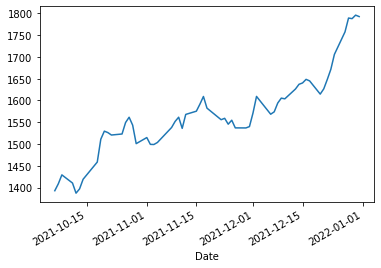

In [31]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
	"""
	Function that exponentially smooths dataset so values are less 'rigid'
	:param alpha: weight factor to weight recent values more
	"""
	return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

In [32]:
data['rsi'] = talib.RSI(data['close'].values, timeperiod=14)
data['macd'], data['macdSignal'], data['macdHist'] = talib.MACD(data.close.values, fastperiod=12, slowperiod=26, signalperiod=9)
data['adx'] = talib.ADX(data.high.values, data.low.values, data.close.values, timeperiod=14)
data['cci'] = talib.CCI(data.high.values, data.low.values, data.close.values, timeperiod=14)
data['slowk'], data['slowd'] = talib.STOCH(data.high.values, data.low.values, data.close.values, fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
data['atr'] = talib.ATR(data.high.values, data.low.values, data.close.values, timeperiod=14)
# Also calculate moving averages for features
data['ema5'] = pd.Series.ewm(data['close'], span=5).mean()
data['ema13'] = pd.Series.ewm(data['close'], span=13).mean()
data['ema26'] = pd.Series.ewm(data['close'], span=26).mean()
# Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
data['normVol'] = pd.Series.ewm(data['volume'], span=5).mean()
del (data['open'])
del (data['high'])
del (data['low'])
del (data['volume'])
del (data['Adj Close'])
print(data.columns)

Index(['close', 'rsi', 'macd', 'macdSignal', 'macdHist', 'adx', 'cci', 'slowk',
       'slowd', 'atr', 'ema5', 'ema13', 'ema26', 'normVol'],
      dtype='object')


In [33]:
live_pred_data = data.iloc[-16:-11]

In [34]:
live_pred_data

,close,rsi,macd,macdSignal,macdHist,adx,cci,slowk,slowd,atr,ema5,ema13,ema26,normVol
Date,,,,,,,,,,,,,,
2021-12-10,1603.525153,60.783936,20.593481,19.806978,0.786502,19.950958,84.953212,78.316312,70.568171,47.082407,1594.199432,1579.830995,1560.719831,2.049563e+06
2021-12-13,1626.031319,64.653280,22.635286,20.372640,2.262646,20.265964,120.635670,83.945862,77.800033,47.265236,1604.810061,1586.431041,1565.557719,2.263627e+06
2021-12-14,1636.865930,66.373377,24.841339,21.266380,3.574959,20.959088,138.574769,86.162703,82.808292,46.957161,1615.495351,1593.636025,1570.839809,2.413638e+06
2021-12-15,1639.943060,66.866538,26.532104,22.319525,4.212580,21.602702,119.926134,89.395988,86.501518,46.088312,1623.644587,1600.251316,1575.958568,2.277133e+06
2021-12-16,1648.202587,68.214053,28.213298,23.498279,4.715019,22.495249,135.632063,90.059823,88.539505,44.847733,1631.830587,1607.101497,1581.309977,2.234168e+06


In [35]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()
print(len(data))

3736


In [36]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    gbt_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    
    # Models which will be used
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier()
    
    # Create a tuple list of our models
    estimators=[('knn', knn), ('rf', rf)]
    ensemble = VotingClassifier(estimators, voting='soft')
    
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        #print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        # fit models
        rf.fit(X_train, y_train)
        knn.fit(X_train, y_train)
        ensemble.fit(X_train, y_train)
        
        # get predictions
        rf_prediction = rf.predict(X_test)
        knn_prediction = knn.predict(X_test)
        ensemble_prediction = ensemble.predict(X_test)
        
#         print('rf prediction is ', rf_prediction)
#         print('knn prediction is ', knn_prediction)
#         print('ensemble prediction is ', ensemble_prediction)
#         print('truth values are ', y_test.values)
        
        # determine accuracy and append to results
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
#         print(rf_accuracy)
#         print(knn_accuracy)
#         print(ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
                
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('ENSEMBLE Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    
cross_Validation(data)

RF Accuracy = 0.7047297297297295
KNN Accuracy = 0.606981981981982
ENSEMBLE Accuracy = 0.6565315315315312


In [39]:
df = data.iloc[-60: -10]

In [40]:
df

,rsi,macd,macdSignal,macdHist,adx,cci,slowk,slowd,atr,ema5,ema13,ema26,normVol,pred
Date,,,,,,,,,,,,,,
2021-09-15,75.532842,45.513276,55.851326,-10.338050,63.611884,127.999038,55.423827,49.121740,32.633715,1444.814565,1433.441321,1390.151207,2.110205e+06,0.0
2021-09-16,72.365687,43.416612,53.364383,-9.947772,63.190351,120.898623,67.538085,56.098090,32.554608,1447.090918,1436.041650,1394.706201,2.050121e+06,0.0
2021-09-17,72.333207,41.274298,50.946366,-9.672069,62.840606,111.139020,71.250063,64.737325,32.661007,1448.588212,1438.261814,1398.919282,2.211927e+06,0.0
2021-09-20,65.473708,38.073786,48.371850,-10.298064,62.842863,76.948581,56.854473,65.214207,34.280614,1445.191812,1438.281414,1401.843707,2.317805e+06,0.0
2021-09-21,69.099116,36.340570,45.965594,-9.625024,62.271405,56.811148,51.808899,59.971145,35.353418,1447.976082,1440.461872,1405.673404,2.211622e+06,0.0
2021-09-22,76.072793,37.682481,44.308971,-6.626491,62.485954,250.771250,56.979693,55.214355,37.375672,1462.844256,1447.907405,1412.110974,2.822588e+06,0.0
2021-09-23,78.579702,39.803930,43.407963,-3.604033,62.913022,282.681763,74.713984,61.167525,37.551177,1479.022241,1456.974663,1419.464103,2.790235e+06,0.0
2021-09-24,78.857835,41.187262,42.963823,-1.776561,63.531760,211.241635,83.341995,71.678557,37.573337,1490.538118,1465.059693,1426.434901,2.956434e+06,0.0
2021-09-27,65.501154,39.252150,42.221488,-2.969338,62.222000,101.531400,73.457999,77.171326,38.891065,1487.561903,1467.423947,1430.521906,2.945839e+06,1.0


In [64]:
rf = RandomForestClassifier()
y = df['pred']
features = [x for x in df.columns if x not in ['pred']]
X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        # fit models
rf.fit(X_train, y_train)

RandomForestClassifier()

In [65]:
rf_prediction = rf.predict(X_test)
rf_prediction

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [66]:
rf_accuracy = accuracy_score(y_test.values, rf_prediction)
rf_accuracy

0.8666666666666667